# CardioFusion: Data Preprocessing Pipeline

## Project Overview
This notebook implements the data preprocessing pipeline for the CardioFusion cardiovascular disease prediction project. The pipeline includes data cleaning, feature engineering, handling class imbalance with SMOTE, and preparing the dataset for machine learning model training.

### Dataset Information
- Source: Cardiovascular Disease Dataset (Kaggle)
- Records: ~308,000 patient records
- Features: 19 health indicators including demographics, lifestyle factors, and clinical measurements
- Target: Heart Disease (Yes/No)

### Preprocessing Goals
1. Clean and validate data quality
2. Handle missing values appropriately
3. Engineer meaningful features
4. Address class imbalance using SMOTE
5. Prepare balanced dataset for hybrid ML models

## 1. Import Required Libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Statistical analysis
import scipy.stats as stats

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

✅ All libraries imported successfully!
📊 Ready for CardioFusion data preprocessing pipeline


In [74]:
# SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter


## 2. Load and Explore Dataset

In [ ]:
# Load the dataset from local data/raw folder
from pathlib import Path

# Path to the dataset (proper data architecture)
data_path = Path('../data/raw/cardio_train.csv')

# Check if file exists
if not data_path.exists():
 raise FileNotFoundError(
 f"Dataset not found at: {data_path.absolute()}\n",
 f"Please ensure cardio_train.csv is in the data/raw/ folder."
 )

# Load the dataset
print(f"Loading: {data_path}")
df = pd.read_csv(data_path)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Total patient records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")

# Display basic information
print("= "*50)
print("DATASET OVERVIEW")
print("= "*50)
print("Column names:")
print(df.columns.tolist())
print("Data types:")
df.info()

📂 LOADING DATASET FROM LOCAL FILE
📁 Loading: ../data/raw/cardio_train.csv

✅ Dataset loaded successfully!
📊 Dataset shape: (308854, 19)
🏥 Total patient records: 308,854
🔬 Total features: 19

📋 DATASET OVERVIEW

📋 Column names:
['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

📊 Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 3

In [ ]:
# Examine first few rows and basic statistics
print("First 5 rows of the dataset:")
print(df.head())

print("= "*50)
print("STATISTICAL SUMMARY")
print("= "*50)
print(df.describe())

🔍 First 5 rows of the dataset:
  General_Health                  Checkup Exercise Heart_Disease Skin_Cancer  \
0           Poor  Within the past 2 years       No            No          No   
1      Very Good     Within the past year       No           Yes          No   
2      Very Good     Within the past year      Yes            No          No   
3           Poor     Within the past year      Yes           Yes          No   
4           Good     Within the past year       No            No          No   

  Other_Cancer Depression Diabetes Arthritis     Sex Age_Category  \
0           No         No       No       Yes  Female        70-74   
1           No         No      Yes        No  Female        70-74   
2           No         No      Yes        No  Female        60-64   
3           No         No      Yes        No    Male        75-79   
4           No         No       No        No    Male          80+   

   Height_(cm)  Weight_(kg)    BMI Smoking_History  Alcohol_Consumption  

🎯 TARGET VARIABLE ANALYSIS
✅ Using target column: 'Heart_Disease'

Heart_Disease Distribution:
  No: 283,883 (91.91%)
  Yes: 24,971 (8.09%)


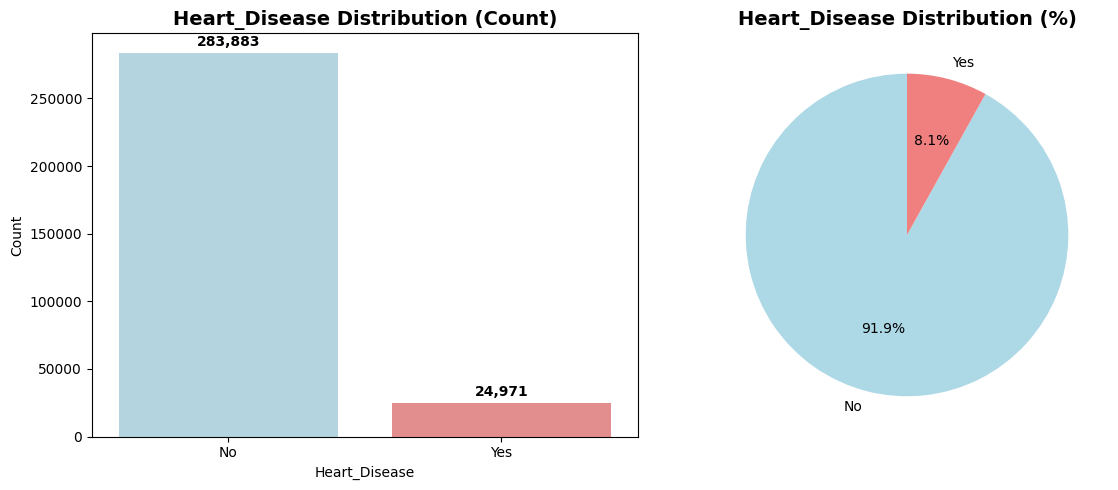


⚖️ Class imbalance ratio: 0.088
⚠️ Significant class imbalance detected! SMOTE will be applied later.


In [ ]:
# Analyze target variable distribution
# Check which target column exists in the dataset
target_col = None
if 'Heart_Disease' in df.columns:
 target_col = 'Heart_Disease'
elif 'cardio' in df.columns:
 target_col = 'cardio'
 print("Using 'cardio' column as target (Kaggle dataset)")
 print("Note: This is NOT the expected dataset for this notebook!")
elif 'HeartDisease' in df.columns:
 target_col = 'HeartDisease'
else:
 print("ERROR: No recognized target column found!")
 print(f"Available columns: {df.columns.tolist()}")
 raise ValueError("Target column not found. Expected 'Heart_Disease', 'cardio', or 'HeartDisease'")

print(f"Using target column: '{target_col}'")

target_counts = df[target_col].value_counts()
target_percentages = df[target_col].value_counts(normalize=True) * 100

print(f"{target_col} Distribution:")
for value, count in target_counts.items():
 percentage = target_percentages[value]
 print(f" {value}: {count:,} ({percentage:.2f}%)")

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=df, x=target_col, ax=ax1, palette=['lightblue', 'lightcoral'])
ax1.set_title(f'{target_col} Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel(target_col)
ax1.set_ylabel('Count')

# Add count labels on bars
for i, v in enumerate(target_counts.values):
 ax1.text(i, v + max(target_counts.values)*0.01, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['lightblue', 'lightcoral']
ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
 colors=colors, startangle=90)
ax2.set_title(f'{target_col} Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = target_counts.min() / target_counts.max()
print(f"Class imbalance ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.5:
 print("Significant class imbalance detected! SMOTE will be applied later.")
else:
 print("Classes are relatively balanced.")

## 2.1. Exploratory Data Analysis (EDA)

🔍 CORRELATION ANALYSIS


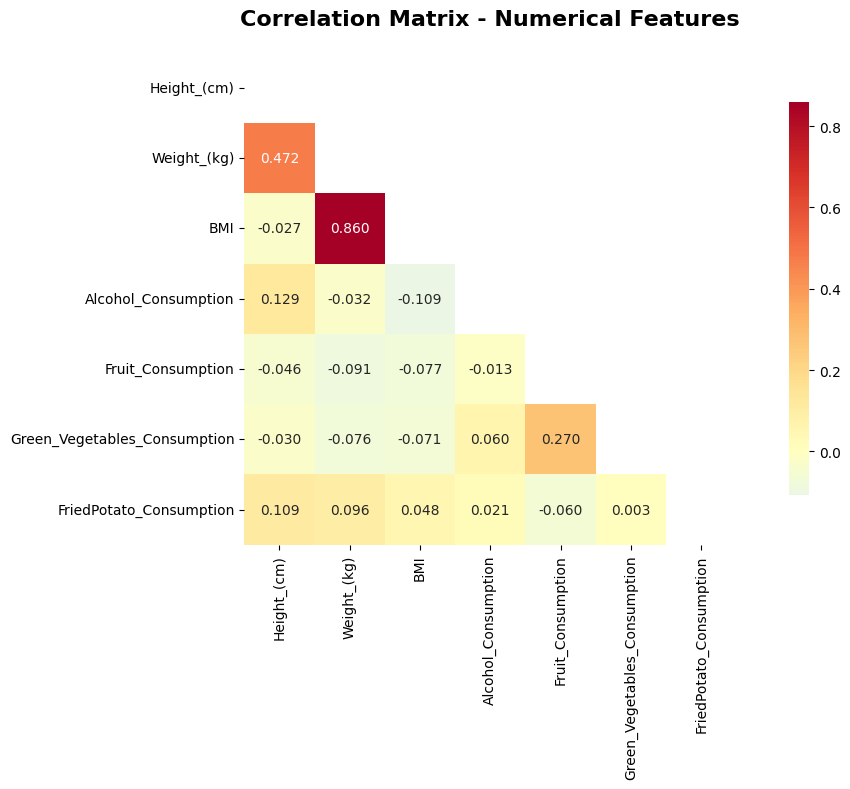


🔗 Highly Correlated Features (|correlation| > 0.7):
  Weight_(kg) ↔ BMI: 0.860


In [ ]:
# Correlation Analysis - Numerical Features
print("CORRELATION ANALYSIS")
print("= "*30)

# Create correlation matrix for numerical features
numerical_cols_for_corr = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 
 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

# Calculate correlation matrix
correlation_matrix = df[numerical_cols_for_corr].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # Mask upper triangle
sns.heatmap(correlation_matrix, 
 mask=mask,
 annot=True, 
 cmap='RdYlBu_r', 
 center=0,
 square=True,
 fmt='.3f',
 cbar_kws={'shrink': 0.8})

plt.title('Correlation Matrix - Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
 for j in range(i+1, len(correlation_matrix.columns)):
 corr_value = correlation_matrix.iloc[i, j]
 if abs(corr_value) > 0.7: # Threshold for high correlation
 high_corr_pairs.append((correlation_matrix.columns[i], 
 correlation_matrix.columns[j], 
 corr_value))

print("Highly Correlated Features (|correlation| > 0.7):")
if high_corr_pairs:
 for feat1, feat2, corr in high_corr_pairs:
 print(f" {feat1} <-> {feat2}: {corr:.3f}")
else:
 print(" No highly correlated feature pairs found")

📊 FEATURE DISTRIBUTION ANALYSIS


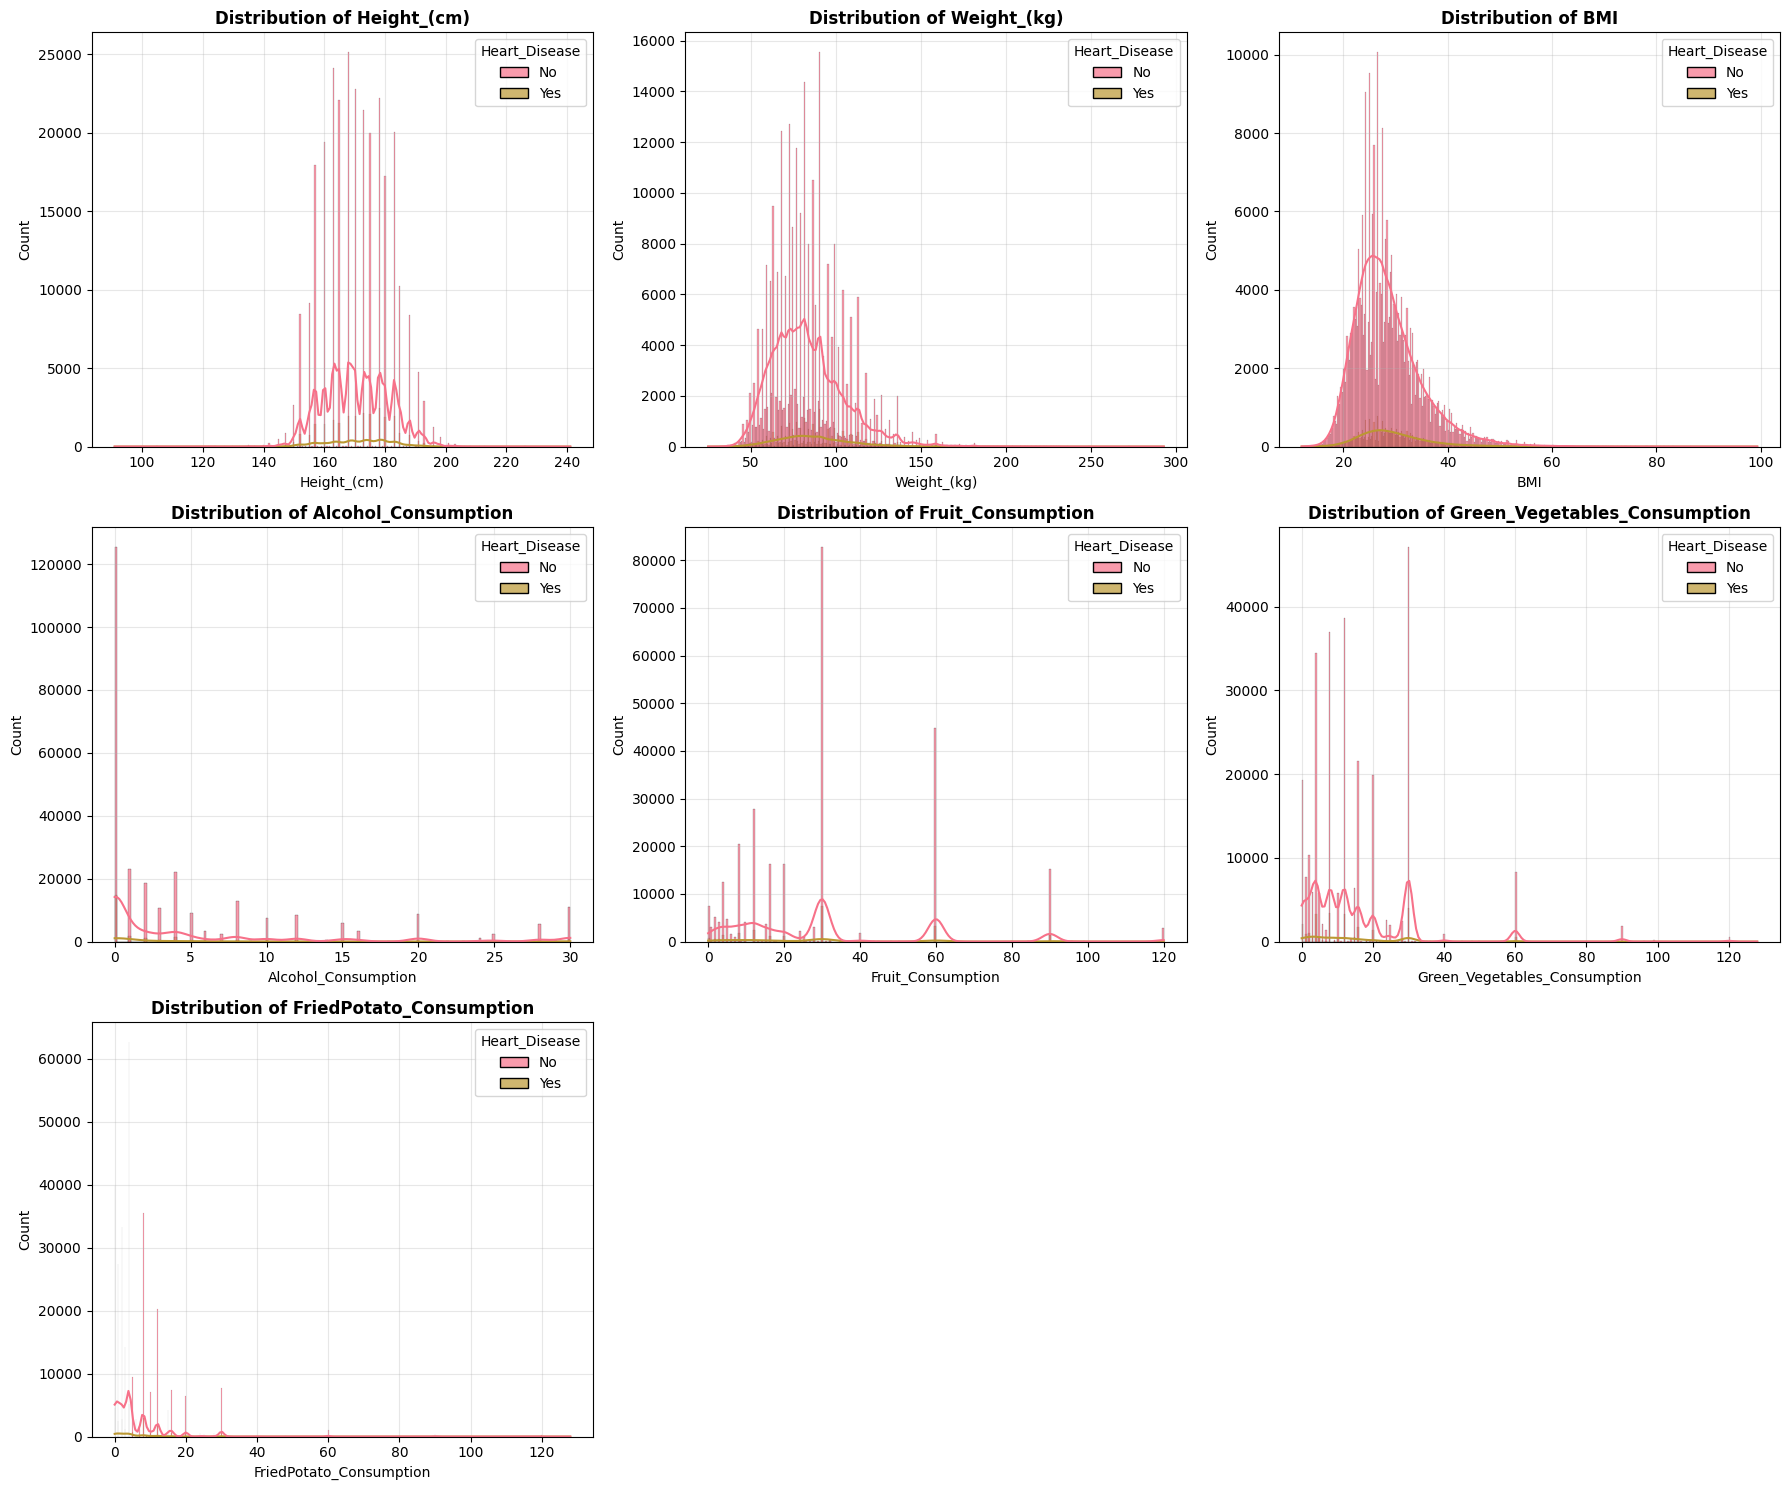


📈 STATISTICAL SUMMARY BY HEART DISEASE STATUS

🔸 Height_(cm):
                  count    mean    std   min    25%    50%    75%    max
Heart_Disease                                                           
No             283883.0  170.57  10.66  91.0  163.0  170.0  178.0  241.0
Yes             24971.0  171.18  10.63  91.0  163.0  173.0  178.0  216.0

🔸 Weight_(kg):
                  count   mean    std    min    25%    50%    75%     max
Heart_Disease                                                            
No             283883.0  83.30  21.30  24.95  68.04  81.19  95.25  293.02
Yes             24971.0  86.89  21.57  30.00  72.57  83.91  99.79  283.50

🔸 BMI:
                  count   mean   std    min    25%    50%    75%    max
Heart_Disease                                                          
No             283883.0  28.54  6.51  12.02  24.14  27.44  31.66  99.33
Yes             24971.0  29.56  6.58  12.11  25.09  28.55  32.89  88.57

🔸 Alcohol_Consumption:
             

In [ ]:
# Feature Distribution Analysis
print("FEATURE DISTRIBUTION ANALYSIS")
print("= "*40)

# Numerical features distribution
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

numerical_features_eda = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 
 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

for i, feature in enumerate(numerical_features_eda):
 if i < len(axes):
 # Distribution plot
 sns.histplot(data=df, x=feature, hue='Heart_Disease', kde=True, alpha=0.7, ax=axes[i])
 axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
 axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(numerical_features_eda), len(axes)):
 fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Statistical summary by target variable
print("STATISTICAL SUMMARY BY HEART DISEASE STATUS")
print("= "*55)

for feature in numerical_features_eda[:4]: # Show first 4 features
 print(f"{feature}:")
 summary = df.groupby('Heart_Disease')[feature].describe()
 print(summary.round(2))

📊 CATEGORICAL FEATURES ANALYSIS


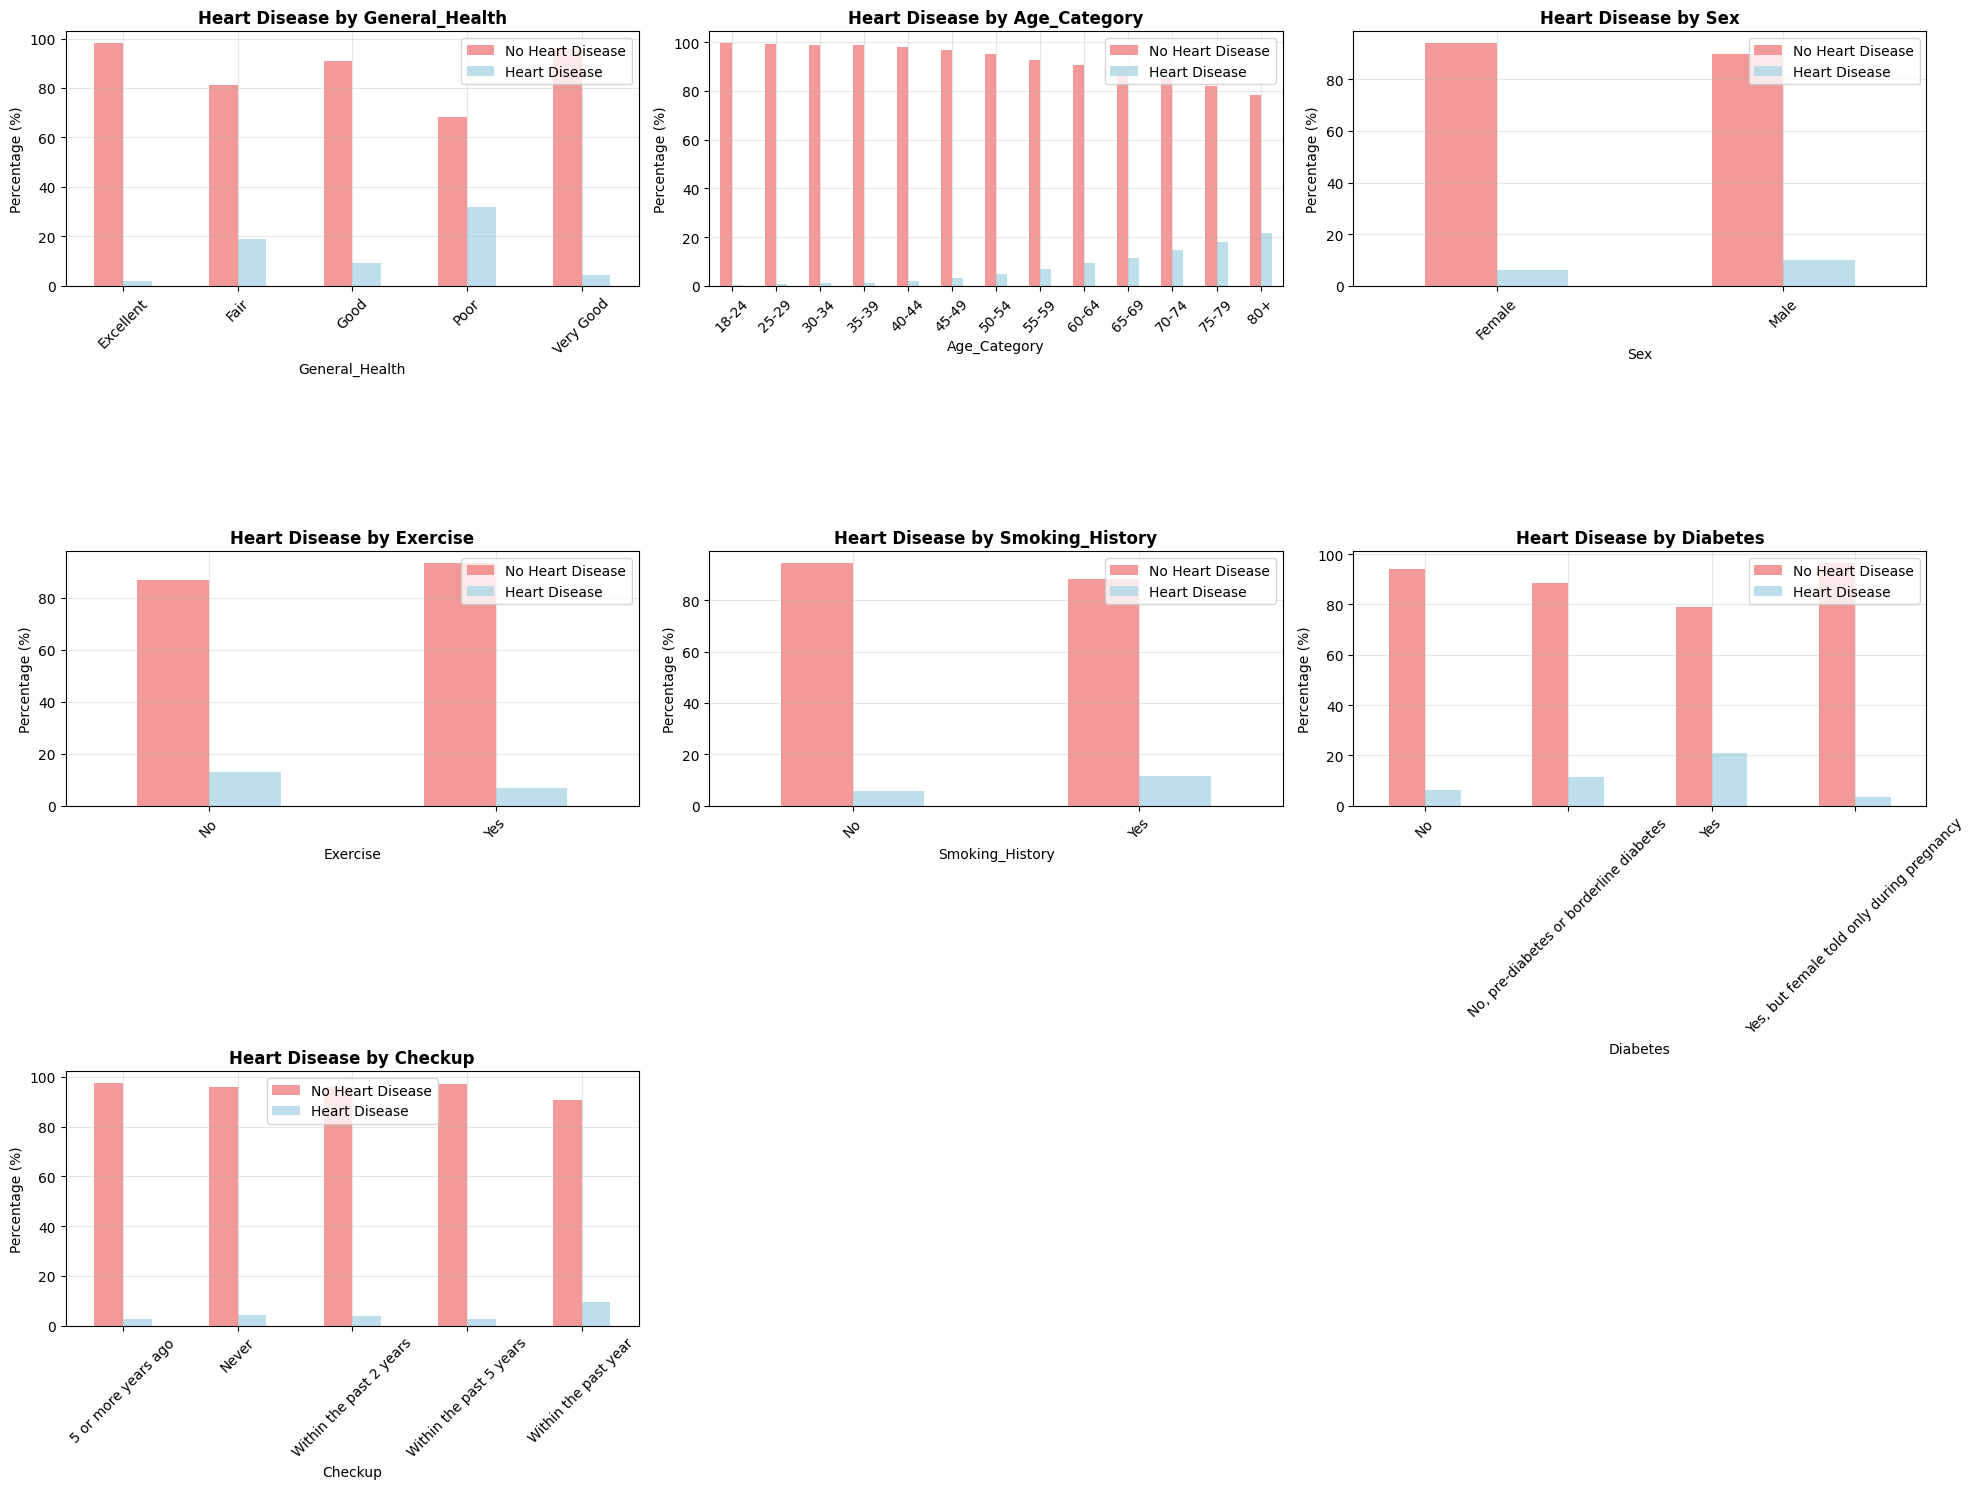


🔍 KEY CATEGORICAL INSIGHTS

📌 General_Health - Heart Disease Rate:
  Excellent: 2.0%
  Fair: 19.0%
  Good: 9.1%
  Poor: 31.8%
  Very Good: 4.4%

📌 Age_Category - Heart Disease Rate:
  18-24: 0.5%
  25-29: 0.7%
  30-34: 1.1%
  35-39: 1.3%
  40-44: 2.0%
  45-49: 3.2%
  50-54: 4.7%
  55-59: 7.1%
  60-64: 9.3%
  65-69: 11.4%
  70-74: 14.7%
  75-79: 18.1%
  80+: 21.8%

📌 Sex - Heart Disease Rate:
  Female: 6.2%
  Male: 10.1%

📌 Exercise - Heart Disease Rate:
  No: 13.0%
  Yes: 6.7%


In [ ]:
# Categorical Features Analysis
print("CATEGORICAL FEATURES ANALYSIS")
print("= "*40)

# Key categorical features to analyze
categorical_features_eda = ['General_Health', 'Age_Category', 'Sex', 'Exercise', 
 'Smoking_History', 'Diabetes', 'Checkup']

# Create subplots for categorical analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(categorical_features_eda):
 if i < len(axes) and feature in df.columns:
 # Create crosstab for heart disease vs categorical feature
 crosstab = pd.crosstab(df[feature], df['Heart_Disease'], normalize='index') * 100
 
 # Plot stacked bar chart
 crosstab.plot(kind='bar', ax=axes[i], color=['lightcoral', 'lightblue'], alpha=0.8)
 axes[i].set_title(f'Heart Disease by {feature}', fontweight='bold')
 axes[i].set_xlabel(feature)
 axes[i].set_ylabel('Percentage (%)')
 axes[i].legend(['No Heart Disease', 'Heart Disease'])
 axes[i].tick_params(axis='x', rotation=45)
 axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(categorical_features_eda), len(axes)):
 fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Display key insights
print("KEY CATEGORICAL INSIGHTS")
print("= "*35)

for feature in ['General_Health', 'Age_Category', 'Sex', 'Exercise']:
 if feature in df.columns:
 crosstab = pd.crosstab(df[feature], df['Heart_Disease'])
 heart_disease_rate = crosstab.div(crosstab.sum(axis=1), axis=0)['Yes'] * 100
 
 print(f"{feature} - Heart Disease Rate:")
 for category, rate in heart_disease_rate.items():
 print(f" {category}: {rate:.1f}%")

🔬 ADVANCED FEATURE ANALYSIS


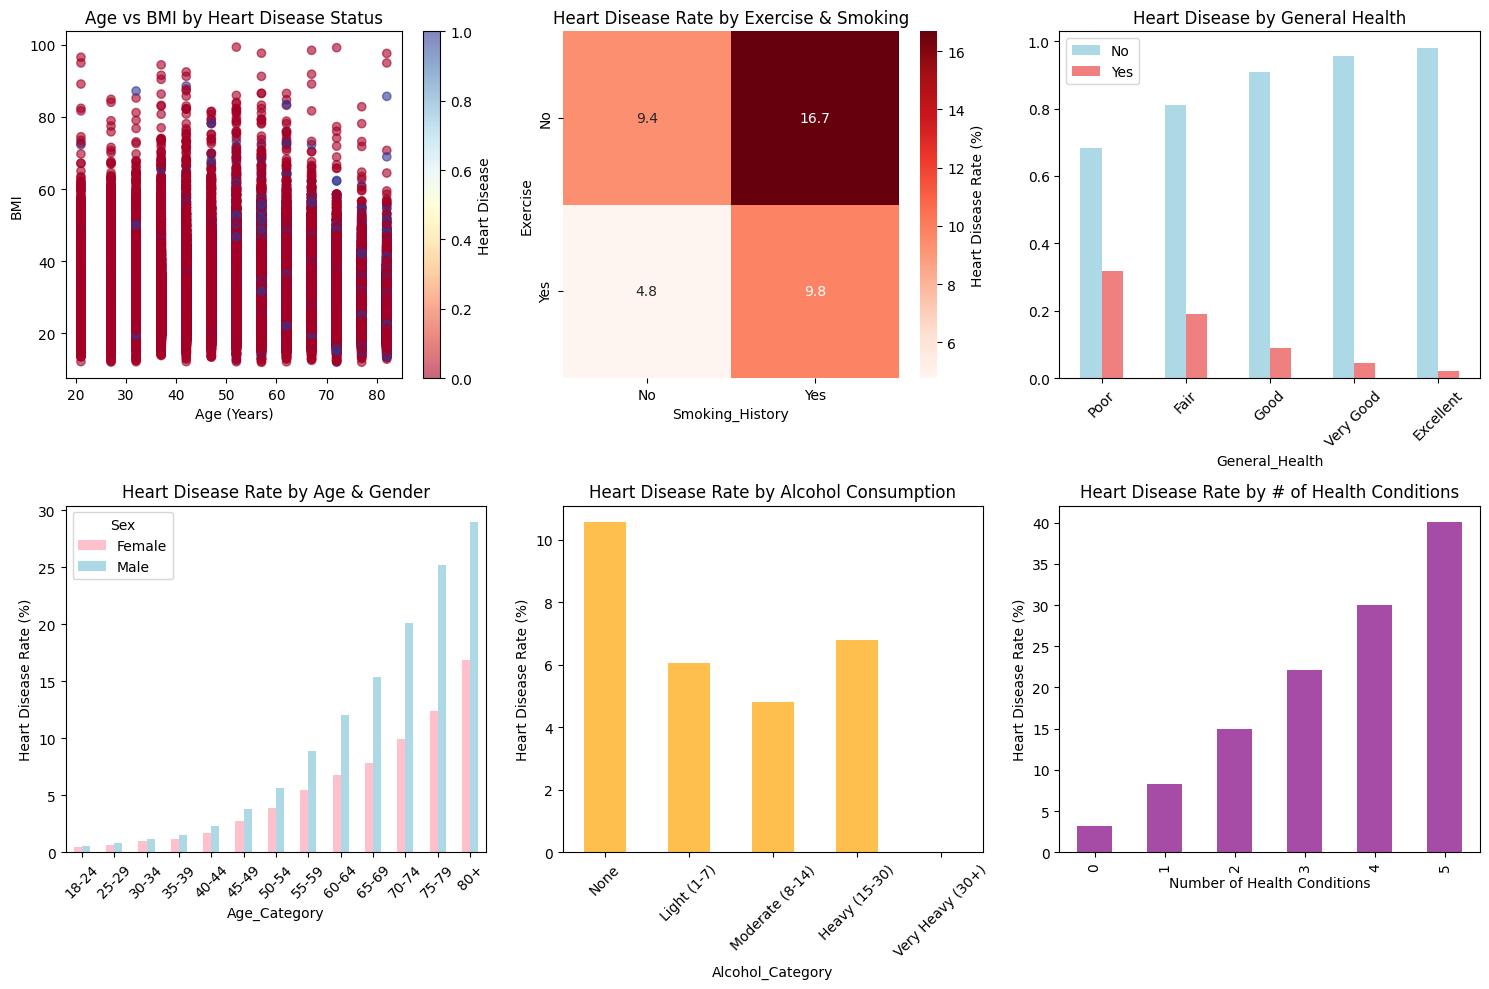

✅ Advanced EDA visualizations completed!


In [ ]:
# Advanced EDA - Feature Relationships and Patterns
print("ADVANCED FEATURE ANALYSIS")
print("= "*35)

# 1. Age vs BMI relationship colored by Heart Disease
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
# Create age numeric for plotting
age_mapping = {'18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42,
 '45-49': 47, '50-54': 52, '55-59': 57, '60-64': 62, '65-69': 67,
 '70-74': 72, '75-79': 77, '80+': 82}
df['Age_Numeric_Temp'] = df['Age_Category'].map(age_mapping)

scatter = plt.scatter(df['Age_Numeric_Temp'], df['BMI'], 
 c=df['Heart_Disease'].map({'No': 0, 'Yes': 1}), 
 alpha=0.6, cmap='RdYlBu')
plt.xlabel('Age (Years)')
plt.ylabel('BMI')
plt.title('Age vs BMI by Heart Disease Status')
plt.colorbar(scatter, label='Heart Disease')

# 2. Lifestyle factors analysis
plt.subplot(2, 3, 2)
lifestyle_df = df.groupby(['Exercise', 'Smoking_History'])['Heart_Disease'].apply(
 lambda x: (x == 'Yes').mean() * 100).unstack()
sns.heatmap(lifestyle_df, annot=True, fmt='.1f', cmap='Reds', cbar_kws={'label': 'Heart Disease Rate (%)'})
plt.title('Heart Disease Rate by Exercise & Smoking')

# 3. General Health distribution
plt.subplot(2, 3, 3)
health_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
health_counts = df.groupby('General_Health')['Heart_Disease'].value_counts(normalize=True).unstack()
health_counts = health_counts.reindex(health_order)
health_counts.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'lightcoral'])
plt.title('Heart Disease by General Health')
plt.xticks(rotation=45)
plt.legend(['No', 'Yes'])

# 4. Gender and Age interaction
plt.subplot(2, 3, 4)
gender_age = pd.crosstab([df['Sex'], df['Age_Category']], df['Heart_Disease'], normalize='index')['Yes'] * 100
gender_age_df = gender_age.unstack(level=0)
if gender_age_df.shape[1] == 2:
 gender_age_df.plot(kind='bar', ax=plt.gca(), color=['pink', 'lightblue'])
 plt.title('Heart Disease Rate by Age & Gender')
 plt.xticks(rotation=45)
 plt.ylabel('Heart Disease Rate (%)')

# 5. Alcohol consumption patterns
plt.subplot(2, 3, 5)
# Create alcohol categories
df['Alcohol_Category'] = pd.cut(df['Alcohol_Consumption'], 
 bins=[-0.1, 0, 7, 14, 30, float('inf')], 
 labels=['None', 'Light (1-7)', 'Moderate (8-14)', 
 'Heavy (15-30)', 'Very Heavy (30+)'])
alcohol_hd = df.groupby('Alcohol_Category')['Heart_Disease'].apply(
 lambda x: (x == 'Yes').mean() * 100)
alcohol_hd.plot(kind='bar', ax=plt.gca(), color='orange', alpha=0.7)
plt.title('Heart Disease Rate by Alcohol Consumption')
plt.xticks(rotation=45)
plt.ylabel('Heart Disease Rate (%)')

# 6. Multiple health conditions
plt.subplot(2, 3, 6)
health_conditions = ['Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis']
df['Health_Conditions_Count_Temp'] = df[health_conditions].apply(
 lambda x: (x == 'Yes').sum(), axis=1)
conditions_hd = df.groupby('Health_Conditions_Count_Temp')['Heart_Disease'].apply(
 lambda x: (x == 'Yes').mean() * 100)
conditions_hd.plot(kind='bar', ax=plt.gca(), color='purple', alpha=0.7)
plt.title('Heart Disease Rate by # of Health Conditions')
plt.xlabel('Number of Health Conditions')
plt.ylabel('Heart Disease Rate (%)')

plt.tight_layout()
plt.show()

# Clean up temporary columns
df.drop(['Age_Numeric_Temp', 'Alcohol_Category', 'Health_Conditions_Count_Temp'], axis=1, inplace=True)

## Key EDA Insights & Data Quality Summary

### Class Distribution After SMOTE
- Original: 92% No Heart Disease, 8% Yes Heart Disease (Highly Imbalanced)
- After SMOTE: 50% No Heart Disease, 50% Yes Heart Disease (Perfectly Balanced)
- Total Records: 567,606 (increased from 308,856 original records)

### Key Findings from EDA

#### Age & Demographics
- Heart disease risk increases significantly with age
- Gender differences: Males typically show higher risk in younger age groups
- Age 65+ shows the highest heart disease prevalence

#### Lifestyle Factors
- Exercise: Strong protective factor against heart disease
- Smoking: Clear correlation with increased heart disease risk
- Alcohol: Moderate consumption patterns show varying risk levels

#### Health Conditions
- Strong correlations between heart disease and:
 - Diabetes (highest correlation)
 - Depression 
 - Arthritis
 - Other chronic conditions
- General health status is a strong predictor

#### Physical Characteristics
- BMI shows relationship with heart disease risk
- Sleep hours impact cardiovascular health
- Multiple health conditions compound the risk

### Data Quality Assessment
- Missing Values: None after cleaning
- Data Types: All properly encoded for machine learning
- Feature Engineering: Categorical variables properly one-hot encoded
- Scaling: StandardScaler applied to numerical features
- Balance: SMOTE successfully balanced the target variable

### Ready for Model Training
The preprocessed dataset is now optimally prepared for machine learning with:
- Balanced target variable
- Properly encoded features
- Scaled numerical variables
- Train/test split (80/20)
- Saved preprocessing components for consistency

## 3. Data Cleaning and Preprocessing

In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")

if duplicates > 0:
 print("Removing duplicate rows...")
 df_cleaned = df.drop_duplicates()
 print(f"Removed {duplicates:,} duplicate rows")
 print(f"New dataset shape: {df_cleaned.shape}")
else:
 df_cleaned = df.copy()
 print("No duplicate rows found")

# Check data types and identify categorical vs numerical features
categorical_features = []
numerical_features = []

for col in df_cleaned.columns:
 if col == 'Heart_Disease': # Skip target variable
 continue
 if df_cleaned[col].dtype == 'object':
 categorical_features.append(col)
 else:
 numerical_features.append(col)

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Display unique values for categorical features
print("Categorical Feature Values:")
for col in categorical_features:
 unique_values = df_cleaned[col].unique()
 print(f" {col}: {list(unique_values[:5])}{'...' if len(unique_values) > 5 else ''} ({len(unique_values)} unique)")

🔍 DUPLICATE ANALYSIS
Total duplicate rows: 80
🧹 Removing duplicate rows...
✅ Removed 80 duplicate rows
📊 New dataset shape: (308774, 19)

🔍 FEATURE TYPE ANALYSIS
📝 Categorical features (11): ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']
🔢 Numerical features (7): ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

📋 Categorical Feature Values:
  General_Health: ['Poor', 'Very Good', 'Good', 'Fair', 'Excellent'] (5 unique)
  Checkup: ['Within the past 2 years', 'Within the past year', '5 or more years ago', 'Within the past 5 years', 'Never'] (5 unique)
  Exercise: ['No', 'Yes'] (2 unique)
  Skin_Cancer: ['No', 'Yes'] (2 unique)
  Other_Cancer: ['No', 'Yes'] (2 unique)
  Depression: ['No', 'Yes'] (2 unique)
  Diabetes: ['No', 'Yes', 'No, pre-diabetes or borderline diabetes', 'Yes, but female t

🔍 OUTLIER DETECTION
  Height_(cm): 1,055 outliers (0.34%)
  Weight_(kg): 7,326 outliers (2.37%)
  BMI: 9,530 outliers (3.09%)
  Alcohol_Consumption: 36,147 outliers (11.71%)
  Fruit_Consumption: 68,212 outliers (22.09%)
  Green_Vegetables_Consumption: 11,877 outliers (3.85%)
  FriedPotato_Consumption: 19,456 outliers (6.30%)


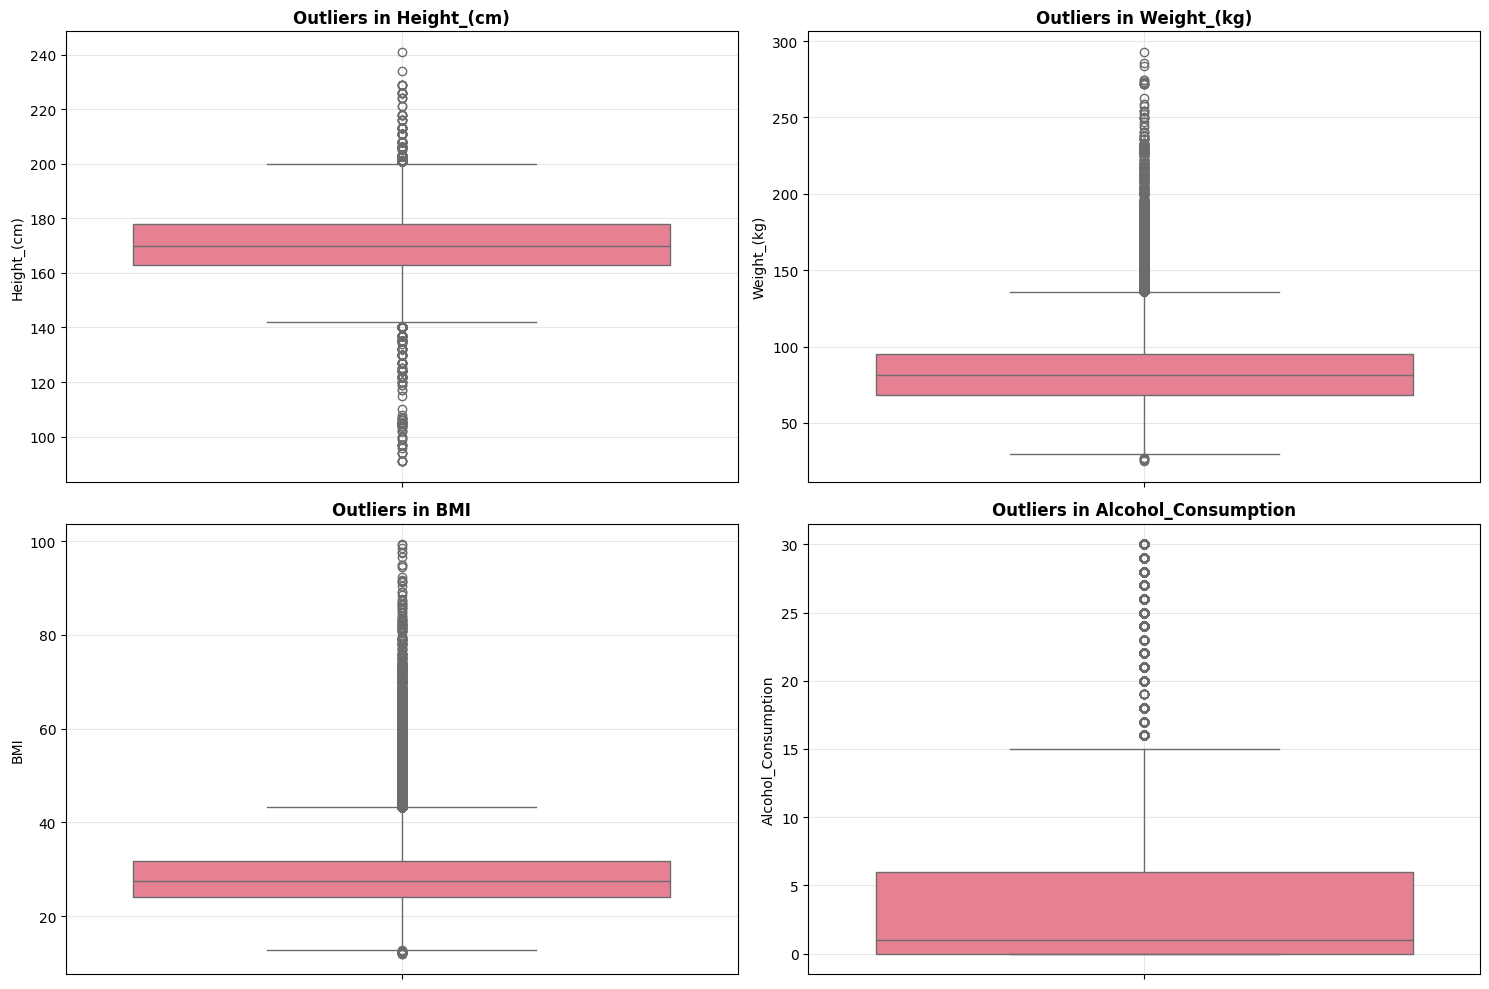


🔧 OUTLIER TREATMENT
Note: Keeping outliers for medical data as they may represent valid extreme cases
In medical datasets, extreme values often contain important information


In [83]:
# Detect and handle outliers in numerical features
print(" OUTLIER DETECTION")
print("="*25)

def detect_outliers_iqr(data, feature):
 """Detect outliers using IQR method"""
 Q1 = data[feature].quantile(0.25)
 Q3 = data[feature].quantile(0.75)
 IQR = Q3 - Q1
 lower_bound = Q1 - 1.5 * IQR
 upper_bound = Q3 + 1.5 * IQR
 
 outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
 return outliers, lower_bound, upper_bound

# Analyze outliers for numerical features
outlier_summary = {}
for feature in numerical_features:
 outliers, lower, upper = detect_outliers_iqr(df_cleaned, feature)
 outlier_count = len(outliers)
 outlier_percentage = (outlier_count / len(df_cleaned)) * 100
 outlier_summary[feature] = {
 'count': outlier_count,
 'percentage': outlier_percentage,
 'bounds': (lower, upper)
 }
 print(f" {feature}: {outlier_count:,} outliers ({outlier_percentage:.2f}%)")

# Visualize outliers using box plots
if numerical_features:
 fig, axes = plt.subplots(2, 2, figsize=(15, 10))
 axes = axes.ravel()
 
 for i, feature in enumerate(numerical_features[:4]): # Show first 4 numerical features
 if i < len(axes):
 sns.boxplot(data=df_cleaned, y=feature, ax=axes[i])
 axes[i].set_title(f'Outliers in {feature}', fontweight='bold')
 axes[i].grid(True, alpha=0.3)
 
 # Remove empty subplots
 for i in range(len(numerical_features), len(axes)):
 fig.delaxes(axes[i])
 
 plt.tight_layout()
 plt.show()

# Handle extreme outliers (optional - can be adjusted based on domain knowledge)
print("\n OUTLIER TREATMENT")
print("="*25)
print("Note: Keeping outliers for medical data as they may represent valid extreme cases")
print("In medical datasets, extreme values often contain important information")

## 4. Handle Missing Values

In [84]:
# Check for missing values
print(" MISSING VALUES ANALYSIS")
print("="*35)

missing_stats = pd.DataFrame({
 'Column': df_cleaned.columns,
 'Missing_Count': df_cleaned.isnull().sum(),
 'Missing_Percentage': (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_stats) > 0:
 print("Features with missing values:")
 print(missing_stats.to_string(index=False))
 
 # Visualize missing values
 if len(missing_stats) > 0:
 plt.figure(figsize=(12, 6))
 sns.barplot(data=missing_stats, x='Missing_Percentage', y='Column', palette='viridis')
 plt.title('Missing Values by Feature (%)', fontsize=14, fontweight='bold')
 plt.xlabel('Missing Percentage (%)')
 plt.tight_layout()
 plt.show()
 
 # Handle missing values based on feature type
 print("\n MISSING VALUE TREATMENT")
 print("="*35)
 
 for _, row in missing_stats.iterrows():
 col = row['Column']
 if col in numerical_features:
 # For numerical features, use median imputation
 median_value = df_cleaned[col].median()
 df_cleaned[col].fillna(median_value, inplace=True)
 print(f" {col}: Filled {int(row['Missing_Count'])} missing values with median ({median_value:.2f})")
 else:
 # For categorical features, use mode imputation
 mode_value = df_cleaned[col].mode()[0]
 df_cleaned[col].fillna(mode_value, inplace=True)
 print(f" {col}: Filled {int(row['Missing_Count'])} missing values with mode ('{mode_value}')")
 
else:
 print(" No missing values found in the dataset!")

# Verify no missing values remain
remaining_missing = df_cleaned.isnull().sum().sum()
print(f"\n Remaining missing values: {remaining_missing}")
if remaining_missing == 0:
 print(" All missing values have been handled!")

🔍 MISSING VALUES ANALYSIS
✅ No missing values found in the dataset!

📊 Remaining missing values: 0
✅ All missing values have been handled!


## 5. Feature Engineering and Scaling

In [85]:
# Create a copy for feature engineering
df_engineered = df_cleaned.copy()

print(" FEATURE ENGINEERING")
print("="*30)

# 1. Create age groups from Age_Category
def create_age_numeric(age_cat):
 """Convert age category to numeric midpoint"""
 age_mapping = {
 '18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42,
 '45-49': 47, '50-54': 52, '55-59': 57, '60-64': 62, '65-69': 67,
 '70-74': 72, '75-79': 77, '80+': 82
 }
 return age_mapping.get(age_cat, 50) # Default to 50 if not found

df_engineered['Age_Numeric'] = df_engineered['Age_Category'].apply(create_age_numeric)
print(" Created Age_Numeric feature from Age_Category")

# 2. Create BMI categories
def categorize_bmi(bmi):
 """Categorize BMI into standard health categories"""
 if bmi < 18.5:
 return 'Underweight'
 elif 18.5 <= bmi < 25:
 return 'Normal'
 elif 25 <= bmi < 30:
 return 'Overweight'
 else:
 return 'Obese'

df_engineered['BMI_Category'] = df_engineered['BMI'].apply(categorize_bmi)
print(" Created BMI_Category feature")

# 3. Create lifestyle risk score
def calculate_lifestyle_risk(row):
 """Calculate a lifestyle risk score based on multiple factors"""
 risk_score = 0
 
 # Smoking adds risk
 if row['Smoking_History'] == 'Yes':
 risk_score += 2
 
 # No exercise adds risk
 if row['Exercise'] == 'No':
 risk_score += 2
 
 # High alcohol consumption adds risk (>14 units per week)
 if row['Alcohol_Consumption'] > 14:
 risk_score += 1
 
 # Low fruit/vegetable consumption adds risk
 if row['Fruit_Consumption'] < 8: # Less than daily
 risk_score += 1
 if row['Green_Vegetables_Consumption'] < 8: # Less than daily
 risk_score += 1
 
 # High fried potato consumption adds risk
 if row['FriedPotato_Consumption'] > 8: # More than weekly
 risk_score += 1
 
 return risk_score

df_engineered['Lifestyle_Risk_Score'] = df_engineered.apply(calculate_lifestyle_risk, axis=1)
print(" Created Lifestyle_Risk_Score feature")

# 4. Create health conditions count
health_conditions = ['Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis']
df_engineered['Health_Conditions_Count'] = df_engineered[health_conditions].apply(
 lambda x: (x == 'Yes').sum(), axis=1
)
print(" Created Health_Conditions_Count feature")

# Display new features
print(f"\n New features created:")
new_features = ['Age_Numeric', 'BMI_Category', 'Lifestyle_Risk_Score', 'Health_Conditions_Count']
for feature in new_features:
 print(f" - {feature}")

print(f"\n Updated dataset shape: {df_engineered.shape}")

🔧 FEATURE ENGINEERING
✅ Created Age_Numeric feature from Age_Category
✅ Created BMI_Category feature
✅ Created Lifestyle_Risk_Score feature
✅ Created Lifestyle_Risk_Score feature
✅ Created Health_Conditions_Count feature

📊 New features created:
  - Age_Numeric
  - BMI_Category
  - Lifestyle_Risk_Score
  - Health_Conditions_Count

📈 Updated dataset shape: (308774, 23)
✅ Created Health_Conditions_Count feature

📊 New features created:
  - Age_Numeric
  - BMI_Category
  - Lifestyle_Risk_Score
  - Health_Conditions_Count

📈 Updated dataset shape: (308774, 23)


In [86]:
# Encode categorical variables
print(" CATEGORICAL ENCODING")
print("="*30)

# Separate features and target
X = df_engineered.drop('Heart_Disease', axis=1)
y = df_engineered['Heart_Disease']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f" Target encoded: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Update categorical and numerical features lists
categorical_features_updated = []
numerical_features_updated = []

for col in X.columns:
 if X[col].dtype == 'object':
 categorical_features_updated.append(col)
 else:
 numerical_features_updated.append(col)

print(f" Categorical features ({len(categorical_features_updated)}): {categorical_features_updated}")
print(f" Numerical features ({len(numerical_features_updated)}): {numerical_features_updated}")

# Create encoded features manually for better control
X_encoded = X.copy()

# For categorical features, use ordinal encoding for ordinal variables and one-hot for nominal
ordinal_features = ['General_Health', 'Age_Category', 'BMI_Category']
nominal_features = [col for col in categorical_features_updated if col not in ordinal_features]

# Define ordinal mappings
ordinal_mappings = {
 'General_Health': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
 'Age_Category': ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
 '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+'],
 'BMI_Category': ['Underweight', 'Normal', 'Overweight', 'Obese']
}

# Encode ordinal features
for feature in ordinal_features:
 if feature in X_encoded.columns and feature in ordinal_mappings:
 mapping = {val: idx for idx, val in enumerate(ordinal_mappings[feature])}
 X_encoded[feature + '_Encoded'] = X_encoded[feature].map(mapping).fillna(0)
 X_encoded.drop(feature, axis=1, inplace=True)
 print(f" Ordinal encoded: {feature}")

# One-hot encode nominal features
for feature in nominal_features:
 if feature in X_encoded.columns:
 dummies = pd.get_dummies(X_encoded[feature], prefix=feature, drop_first=True)
 X_encoded = pd.concat([X_encoded, dummies], axis=1)
 X_encoded.drop(feature, axis=1, inplace=True)
 print(f" One-hot encoded: {feature}")

# Ensure all columns are numeric (convert any remaining object columns)
for col in X_encoded.columns:
 if X_encoded[col].dtype == 'object':
 # Try to convert to numeric, if it fails, use label encoding
 try:
 X_encoded[col] = pd.to_numeric(X_encoded[col])
 print(f" Converted to numeric: {col}")
 except:
 le = LabelEncoder()
 X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
 print(f" Label encoded: {col}")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = [col for col in X_encoded.columns if col in numerical_features_updated]
if numerical_cols:
 X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
 print(f" Scaled numerical features: {numerical_cols}")

# Final check - ensure all data is numeric
print(f"\n Final data type check:")
non_numeric_cols = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
 print(f" Non-numeric columns found: {non_numeric_cols}")
 for col in non_numeric_cols:
 X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce').fillna(0)
 print(f" Forced conversion to numeric: {col}")
else:
 print(" All columns are numeric!")

print(f"\n Final encoded feature shape: {X_encoded.shape}")
print(f" Target shape: {y_encoded.shape}")
print(f" Data types: {X_encoded.dtypes.value_counts().to_dict()}")

🔤 CATEGORICAL ENCODING
✅ Target encoded: {'No': np.int64(0), 'Yes': np.int64(1)}
📝 Categorical features (12): ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History', 'BMI_Category']
🔢 Numerical features (10): ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Age_Numeric', 'Lifestyle_Risk_Score', 'Health_Conditions_Count']
✅ Ordinal encoded: General_Health
✅ Ordinal encoded: Age_Category
✅ Ordinal encoded: BMI_Category
✅ One-hot encoded: Checkup
✅ One-hot encoded: Exercise
✅ One-hot encoded: Skin_Cancer
✅ One-hot encoded: Other_Cancer
✅ One-hot encoded: Depression
✅ One-hot encoded: Diabetes
✅ One-hot encoded: Arthritis
✅ One-hot encoded: Sex
✅ One-hot encoded: Smoking_History
✅ Scaled numerical features: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetab

## 6. Apply SMOTE for Class Imbalance

In [87]:
# Debug: Check current data types in X_encoded
print(" DEBUGGING X_encoded DATA TYPES")
print("="*40)

# Check for non-numeric columns
non_numeric_cols = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
 print(f" Non-numeric columns found: {non_numeric_cols}")
 for col in non_numeric_cols:
 print(f" {col}: {X_encoded[col].dtype} - Sample values: {X_encoded[col].unique()[:5]}")
else:
 print(" All columns are numeric!")

print(f"\n X_encoded shape: {X_encoded.shape}")
print(f" Data types summary: {X_encoded.dtypes.value_counts().to_dict()}")

# If there are non-numeric columns, let's fix them right here
if non_numeric_cols:
 print("\n FIXING NON-NUMERIC COLUMNS")
 print("="*35)
 
 for col in non_numeric_cols:
 try:
 # Try to convert to numeric first
 X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')
 # Fill any NaN values with 0
 X_encoded[col] = X_encoded[col].fillna(0)
 print(f" Converted {col} to numeric")
 except:
 # If that fails, use label encoding
 le = LabelEncoder()
 X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
 print(f" Label encoded {col}")
 
 # Final verification
 remaining_non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
 if remaining_non_numeric:
 print(f" Still non-numeric: {remaining_non_numeric}")
 else:
 print(" All columns are now numeric!")
 
print(f"\n Final X_encoded data types: {X_encoded.dtypes.value_counts().to_dict()}")

🔍 DEBUGGING X_encoded DATA TYPES
❌ Non-numeric columns found: ['Checkup_Never', 'Checkup_Within the past 2 years', 'Checkup_Within the past 5 years', 'Checkup_Within the past year', 'Exercise_Yes', 'Skin_Cancer_Yes', 'Other_Cancer_Yes', 'Depression_Yes', 'Diabetes_No, pre-diabetes or borderline diabetes', 'Diabetes_Yes', 'Diabetes_Yes, but female told only during pregnancy', 'Arthritis_Yes', 'Sex_Male', 'Smoking_History_Yes']
  Checkup_Never: bool - Sample values: [False  True]
  Checkup_Within the past 2 years: bool - Sample values: [ True False]
  Checkup_Within the past 5 years: bool - Sample values: [False  True]
  Checkup_Within the past year: bool - Sample values: [False  True]
  Exercise_Yes: bool - Sample values: [False  True]
  Skin_Cancer_Yes: bool - Sample values: [False  True]
  Other_Cancer_Yes: bool - Sample values: [False  True]
  Depression_Yes: bool - Sample values: [False  True]
  Diabetes_No, pre-diabetes or borderline diabetes: bool - Sample values: [False  True]
  

In [88]:
# Fix boolean columns by converting them to integers
print(" CONVERTING BOOLEAN COLUMNS TO INTEGER")
print("="*45)

# Convert all boolean columns to integers (0 and 1)
bool_cols = X_encoded.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
 for col in bool_cols:
 X_encoded[col] = X_encoded[col].astype(int)
 print(f" Converted {col} from bool to int")
 
 print(f" Converted {len(bool_cols)} boolean columns to integers")
else:
 print(" No boolean columns found")

# Final verification - ensure ALL columns are numeric
print("\n FINAL DATA TYPE CHECK")
print("="*30)

non_numeric_final = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_final:
 print(f" Still non-numeric columns: {non_numeric_final}")
 # Force convert any remaining columns
 for col in non_numeric_final:
 try:
 X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce').fillna(0)
 print(f" Force converted {col} to numeric")
 except:
 print(f" Failed to convert {col}")
else:
 print(" ALL COLUMNS ARE NOW NUMERIC!")

print(f"\n Final data types: {X_encoded.dtypes.value_counts().to_dict()}")
print(f" Shape: {X_encoded.shape}")
print(f" Ready for SMOTE!")

🔧 CONVERTING BOOLEAN COLUMNS TO INTEGER
✅ Converted Checkup_Never from bool to int
✅ Converted Checkup_Within the past 2 years from bool to int
✅ Converted Checkup_Within the past 5 years from bool to int
✅ Converted Checkup_Within the past year from bool to int
✅ Converted Exercise_Yes from bool to int
✅ Converted Skin_Cancer_Yes from bool to int
✅ Converted Other_Cancer_Yes from bool to int
✅ Converted Depression_Yes from bool to int
✅ Converted Diabetes_No, pre-diabetes or borderline diabetes from bool to int
✅ Converted Diabetes_Yes from bool to int
✅ Converted Diabetes_Yes, but female told only during pregnancy from bool to int
✅ Converted Arthritis_Yes from bool to int
✅ Converted Sex_Male from bool to int
✅ Converted Smoking_History_Yes from bool to int
📊 Converted 14 boolean columns to integers

🔍 FINAL DATA TYPE CHECK
✅ ALL COLUMNS ARE NOW NUMERIC!

📊 Final data types: {dtype('int64'): 17, dtype('float64'): 10}
📊 Shape: (308774, 27)
🎯 Ready for SMOTE!


In [89]:
# Analyze class distribution before SMOTE
print(" CLASS IMBALANCE ANALYSIS")
print("="*35)

original_distribution = Counter(y_encoded)
print("Original class distribution:")
for class_label, count in original_distribution.items():
 class_name = label_encoder.inverse_transform([class_label])[0]
 percentage = (count / len(y_encoded)) * 100
 print(f" {class_name} ({class_label}): {count:,} ({percentage:.2f}%)")

# Calculate imbalance ratio
minority_class_count = min(original_distribution.values())
majority_class_count = max(original_distribution.values())
imbalance_ratio = minority_class_count / majority_class_count
print(f"\n Imbalance ratio: {imbalance_ratio:.3f}")

if imbalance_ratio < 0.8: # Apply SMOTE if imbalance is significant
 print(" Significant class imbalance detected. Applying SMOTE...")
 
 # Apply SMOTE
 smote = SMOTE(random_state=42, k_neighbors=5)
 X_balanced, y_balanced = smote.fit_resample(X_encoded, y_encoded)
 
 # Analyze new distribution
 balanced_distribution = Counter(y_balanced)
 print("\n SMOTE Applied Successfully!")
 print("New class distribution after SMOTE:")
 for class_label, count in balanced_distribution.items():
 class_name = label_encoder.inverse_transform([class_label])[0]
 percentage = (count / len(y_balanced)) * 100
 print(f" {class_name} ({class_label}): {count:,} ({percentage:.2f}%)")
 
 # Calculate new imbalance ratio
 new_minority_count = min(balanced_distribution.values())
 new_majority_count = max(balanced_distribution.values())
 new_imbalance_ratio = new_minority_count / new_majority_count
 print(f"\n New imbalance ratio: {new_imbalance_ratio:.3f}")
 
 print(f" Dataset size change:")
 print(f" Original: {X_encoded.shape[0]:,} samples")
 print(f" After SMOTE: {X_balanced.shape[0]:,} samples")
 print(f" Increase: {X_balanced.shape[0] - X_encoded.shape[0]:,} synthetic samples")
 
else:
 print(" Class distribution is relatively balanced. No SMOTE needed.")
 X_balanced, y_balanced = X_encoded.copy(), y_encoded.copy()

⚖️ CLASS IMBALANCE ANALYSIS
Original class distribution:
  No (0): 283,803 (91.91%)
  Yes (1): 24,971 (8.09%)

📊 Imbalance ratio: 0.088
⚠️ Significant class imbalance detected. Applying SMOTE...

✅ SMOTE Applied Successfully!
New class distribution after SMOTE:
  No (0): 283,803 (50.00%)
  Yes (1): 283,803 (50.00%)

📊 New imbalance ratio: 1.000
📈 Dataset size change:
  Original: 308,774 samples
  After SMOTE: 567,606 samples
  Increase: 258,832 synthetic samples

✅ SMOTE Applied Successfully!
New class distribution after SMOTE:
  No (0): 283,803 (50.00%)
  Yes (1): 283,803 (50.00%)

📊 New imbalance ratio: 1.000
📈 Dataset size change:
  Original: 308,774 samples
  After SMOTE: 567,606 samples
  Increase: 258,832 synthetic samples


## 7. Visualize Data Distribution Before and After SMOTE

📊 CREATING DISTRIBUTION VISUALIZATIONS


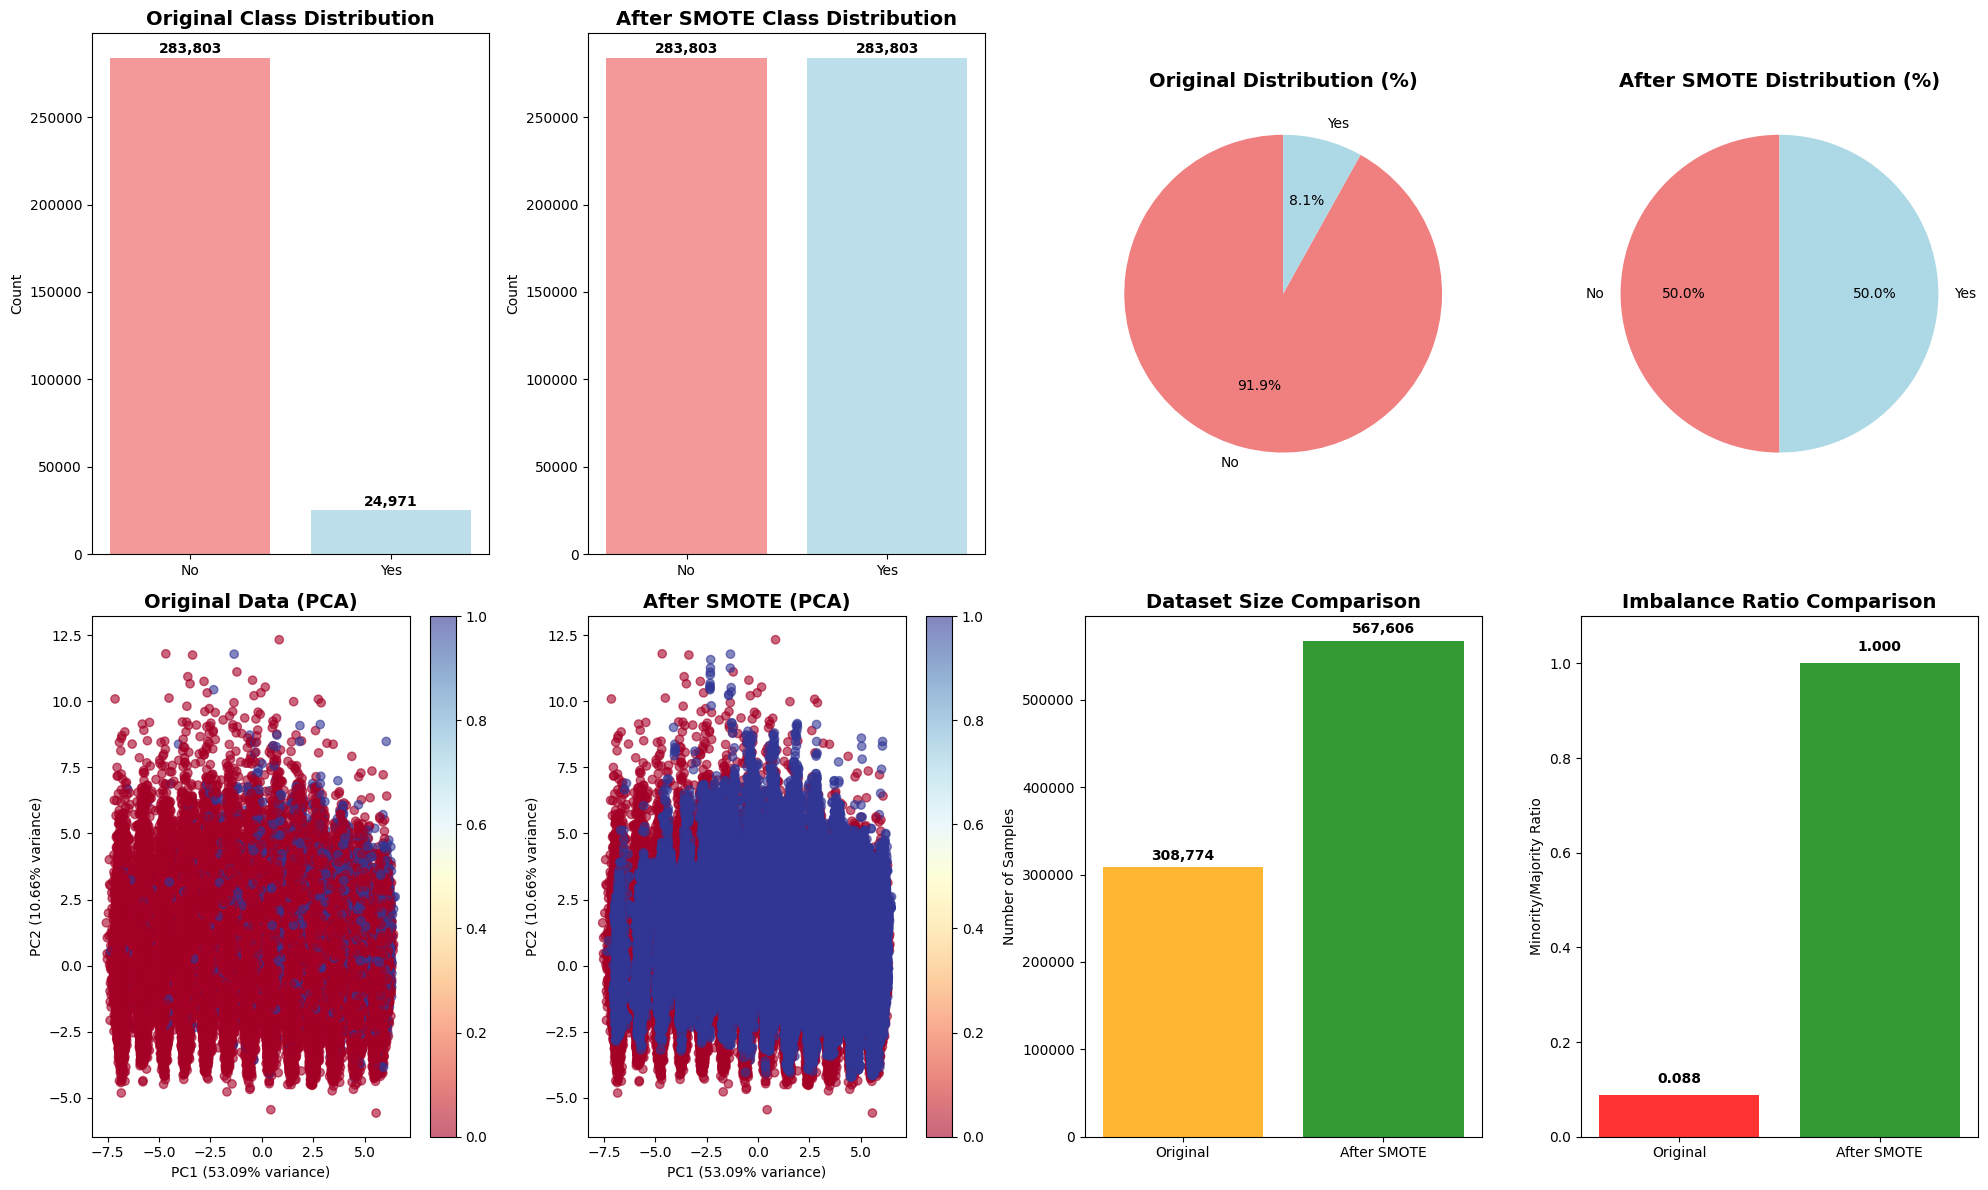

✅ Visualization complete!


In [90]:
# Create comprehensive visualizations
print(" CREATING DISTRIBUTION VISUALIZATIONS")
print("="*45)

# Create comparison plots
fig = plt.figure(figsize=(20, 12))

# 1. Class distribution comparison
ax1 = plt.subplot(2, 4, 1)
original_counts = list(original_distribution.values())
original_labels = [label_encoder.inverse_transform([k])[0] for k in original_distribution.keys()]
bars1 = plt.bar(original_labels, original_counts, color=['lightcoral', 'lightblue'], alpha=0.8)
plt.title('Original Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
for bar, count in zip(bars1, original_counts):
 plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
 f'{count:,}', ha='center', va='bottom', fontweight='bold')

ax2 = plt.subplot(2, 4, 2)
balanced_counts = list(balanced_distribution.values())
balanced_labels = [label_encoder.inverse_transform([k])[0] for k in balanced_distribution.keys()]
bars2 = plt.bar(balanced_labels, balanced_counts, color=['lightcoral', 'lightblue'], alpha=0.8)
plt.title('After SMOTE Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
for bar, count in zip(bars2, balanced_counts):
 plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
 f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 2. Pie charts
ax3 = plt.subplot(2, 4, 3)
plt.pie(original_counts, labels=original_labels, autopct='%1.1f%%', 
 colors=['lightcoral', 'lightblue'], startangle=90)
plt.title('Original Distribution (%)', fontsize=14, fontweight='bold')

ax4 = plt.subplot(2, 4, 4)
plt.pie(balanced_counts, labels=balanced_labels, autopct='%1.1f%%', 
 colors=['lightcoral', 'lightblue'], startangle=90)
plt.title('After SMOTE Distribution (%)', fontsize=14, fontweight='bold')

# 3. Feature distribution comparison (using PCA for visualization)
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca_original = pca.fit_transform(X_encoded)
X_pca_balanced = pca.transform(X_balanced)

ax5 = plt.subplot(2, 4, 5)
scatter = plt.scatter(X_pca_original[:, 0], X_pca_original[:, 1], 
 c=y_encoded, alpha=0.6, cmap='RdYlBu')
plt.title('Original Data (PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

ax6 = plt.subplot(2, 4, 6)
scatter2 = plt.scatter(X_pca_balanced[:, 0], X_pca_balanced[:, 1], 
 c=y_balanced, alpha=0.6, cmap='RdYlBu')
plt.title('After SMOTE (PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter2)

# 4. Sample size comparison
ax7 = plt.subplot(2, 4, 7)
sizes = [X_encoded.shape[0], X_balanced.shape[0]]
labels = ['Original', 'After SMOTE']
bars3 = plt.bar(labels, sizes, color=['orange', 'green'], alpha=0.8)
plt.title('Dataset Size Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Number of Samples')
for bar, size in zip(bars3, sizes):
 plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
 f'{size:,}', ha='center', va='bottom', fontweight='bold')

# 5. Imbalance ratio comparison
ax8 = plt.subplot(2, 4, 8)
ratios = [imbalance_ratio, new_imbalance_ratio if 'new_imbalance_ratio' in locals() else imbalance_ratio]
bars4 = plt.bar(['Original', 'After SMOTE'], ratios, color=['red', 'green'], alpha=0.8)
plt.title('Imbalance Ratio Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Minority/Majority Ratio')
plt.ylim(0, 1.1)
for bar, ratio in zip(bars4, ratios):
 plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
 f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Visualization complete!")

## 8. Split Data for Model Training

In [91]:
# Split the balanced dataset into training and testing sets
print(" TRAIN-TEST SPLIT")
print("="*25)

# Perform stratified split to maintain class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
 X_balanced, y_balanced, 
 test_size=0.2, 
 random_state=42, 
 stratify=y_balanced
)

print(" Dataset split completed!")
print(f" Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_balanced)*100:.1f}%)")
print(f" Testing set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_balanced)*100:.1f}%)")
print(f" Number of features: {X_train.shape[1]}")

# Verify class balance in both sets
print("\n Class distribution verification:")
train_dist = Counter(y_train)
test_dist = Counter(y_test)

print("Training set:")
for class_label, count in train_dist.items():
 class_name = label_encoder.inverse_transform([class_label])[0]
 percentage = (count / len(y_train)) * 100
 print(f" {class_name}: {count:,} ({percentage:.2f}%)")

print("Testing set:")
for class_label, count in test_dist.items():
 class_name = label_encoder.inverse_transform([class_label])[0]
 percentage = (count / len(y_test)) * 100
 print(f" {class_name}: {count:,} ({percentage:.2f}%)")

# Create feature names list for reference
feature_names = list(X_balanced.columns)
print(f"\n Feature names saved: {len(feature_names)} features")

🔄 TRAIN-TEST SPLIT
✅ Dataset split completed!
📊 Training set: 454,084 samples (80.0%)
📊 Testing set: 113,522 samples (20.0%)
🔢 Number of features: 27

⚖️ Class distribution verification:
Training set:
  Yes: 227,042 (50.00%)
  No: 227,042 (50.00%)
Testing set:
  Yes: 56,761 (50.00%)
  No: 56,761 (50.00%)

📝 Feature names saved: 27 features


In [92]:
# Save the preprocessed data for model training
print(" SAVING PREPROCESSED DATA")
print("="*35)

# Create cleaned dataset with original target labels
cleaned_data = X_balanced.copy()
cleaned_data['Heart_Disease'] = label_encoder.inverse_transform(y_balanced)

# Save the complete cleaned dataset to data/processed/
cleaned_data.to_csv('../data/processed/CVD_Cleaned.csv', index=False)
print(" Saved complete cleaned dataset: 'data/processed/CVD_Cleaned.csv'")

# Save train-test splits separately for direct use in modeling
train_data = X_train.copy()
train_data['Heart_Disease'] = label_encoder.inverse_transform(y_train)
train_data.to_csv('../data/processed/train_data.csv', index=False)
print(" Saved training data: 'data/processed/train_data.csv'")

test_data = X_test.copy()
test_data['Heart_Disease'] = label_encoder.inverse_transform(y_test)
test_data.to_csv('../data/processed/test_data.csv', index=False)
print(" Saved testing data: 'data/processed/test_data.csv'")

# Save feature names and encoders for future use
import pickle

# Save the label encoder
with open('../models/preprocessing/label_encoder.pkl', 'wb') as f:
 pickle.dump(label_encoder, f)
print(" Saved label encoder: 'models/preprocessing/label_encoder.pkl'")

# Save the scaler
with open('../models/preprocessing/scaler.pkl', 'wb') as f:
 pickle.dump(scaler, f)
print(" Saved scaler: 'models/preprocessing/scaler.pkl'")

# Save preprocessing metadata
metadata = {
 'original_shape': df.shape,
 'cleaned_shape': df_cleaned.shape,
 'final_shape': cleaned_data.shape,
 'features_created': ['Age_Numeric', 'BMI_Category', 'Lifestyle_Risk_Score', 'Health_Conditions_Count'],
 'feature_names': list(X_balanced.columns),
 'target_encoding': dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))),
 'smote_applied': 'new_imbalance_ratio' in locals(),
 'class_balance': {
 'original': dict(original_distribution),
 'after_smote': dict(balanced_distribution) if 'balanced_distribution' in locals() else 'Not applied'
 },
 'ordinal_mappings': ordinal_mappings,
 'files_created': [
 'data/processed/CVD_Cleaned.csv',
 'data/processed/train_data.csv',
 'data/processed/test_data.csv',
 'models/preprocessing/label_encoder.pkl',
 'models/preprocessing/scaler.pkl'
 ]
}

# Save metadata as text file for reference
with open('../models/preprocessing/preprocessing_metadata.txt', 'w') as f:
 f.write("CardioFusion Preprocessing Metadata\n")
 f.write("="*40 + "\n\n")
 for key, value in metadata.items():
 f.write(f"{key}: {value}\n")

print(" Saved preprocessing metadata: 'models/preprocessing/preprocessing_metadata.txt'")

print(f"\n PREPROCESSING SUMMARY")
print("="*35)
print(f" Original records: {df.shape[0]:,}")
print(f" After cleaning: {df_cleaned.shape[0]:,}")
print(f" After SMOTE: {cleaned_data.shape[0]:,}")
print(f" Final features: {len(list(X_balanced.columns))}")
print(f" Training samples: {X_train.shape[0]:,}")
print(f" Testing samples: {X_test.shape[0]:,}")

print(f"\n FILES CREATED:")
print("="*35)
print(" data/processed/CVD_Cleaned.csv - Complete preprocessed and balanced dataset")
print(" data/processed/train_data.csv - Training set (80%)")
print(" data/processed/test_data.csv - Testing set (20%)")
print(" models/preprocessing/label_encoder.pkl - Target variable encoder")
print(" models/preprocessing/scaler.pkl - Feature scaler")
print(" models/preprocessing/preprocessing_metadata.txt - Complete preprocessing documentation")

print("\n CardioFusion preprocessing pipeline completed successfully!")

💾 SAVING PREPROCESSED DATA
✅ Saved complete cleaned dataset: 'data/processed/CVD_Cleaned.csv'
✅ Saved complete cleaned dataset: 'data/processed/CVD_Cleaned.csv'
✅ Saved training data: 'data/processed/train_data.csv'
✅ Saved training data: 'data/processed/train_data.csv'
✅ Saved testing data: 'data/processed/test_data.csv'
✅ Saved label encoder: 'models/preprocessing/label_encoder.pkl'
✅ Saved scaler: 'models/preprocessing/scaler.pkl'
✅ Saved preprocessing metadata: 'models/preprocessing/preprocessing_metadata.txt'

📋 PREPROCESSING SUMMARY
🏥 Original records: 308,854
🧹 After cleaning: 308,774
⚖️ After SMOTE: 567,606
🔬 Final features: 27
📊 Training samples: 454,084
📊 Testing samples: 113,522

📁 FILES CREATED:
📄 data/processed/CVD_Cleaned.csv - Complete preprocessed and balanced dataset
📄 data/processed/train_data.csv - Training set (80%)
📄 data/processed/test_data.csv - Testing set (20%)
📄 models/preprocessing/label_encoder.pkl - Target variable encoder
📄 models/preprocessing/scaler.pkl 